
## Log RV based features

In [1]:
#import libraries
import pandas as pd
import sqlite3
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import numpy as np
warnings.filterwarnings('ignore')
%matplotlib inline


### Read in the database 

In [2]:
conn = sqlite3.connect('cba_log_rv.sqlite')

query_table1 = '''SELECT *
             FROM log_rv;'''

df = pd.read_sql(query_table1, conn)


In [3]:
query_table2 = '''SELECT *
             FROM log_rv_feature;'''

df2 = pd.read_sql(query_table2, conn)


### Data Preperation

In [4]:
#merging table 1 and 2 
data = df.merge(df2, how='inner', on='date')
data = data.set_index('date')
data.head(5)

log_rv  log_rv_lag1  log_rv_avg5  log_rv_avg22  log_rv_avg253  \
date                                                                          
2003-01-07 -0.195388    -0.741694    -0.449644     -0.515572      -0.367086   
2003-01-08 -0.779210    -0.195388    -0.545231     -0.521978      -0.365305   
2003-01-09 -0.196713    -0.779210    -0.463997     -0.551932      -0.365947   
2003-01-10  0.067592    -0.196713    -0.436124     -0.567596      -0.363599   
2003-01-13 -0.838226     0.067592    -0.369083     -0.543945      -0.359683   

            log_rv_up  
date                   
2003-01-07          0  
2003-01-08          0  
2003-01-09          0  
2003-01-10          0  
2003-01-13          0

Note: Initially, I tried to create some extra features by averaging different combinations of already available variables, example:
data['log_rv_avg_1_5_22'] = data[['log_rv_lag1', 'log_rv_avg5']].mean(axis=1).

Doing this will lead to multicolinearity, and thus violating a basic assumption for Simple Regression Model. Alternatively, if we wish to use any other model, adding highly coorelated features will lead to overfitting (extra features will lead to adding more random variation), while adding very little to the model itself.



### Inspect the data

In [5]:
data.info()
#No null values

<class 'pandas.core.frame.DataFrame'>
Index: 4699 entries, 2003-01-07 to 2021-08-20
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   log_rv         4699 non-null   float64
 1   log_rv_lag1    4699 non-null   float64
 2   log_rv_avg5    4699 non-null   float64
 3   log_rv_avg22   4699 non-null   float64
 4   log_rv_avg253  4699 non-null   float64
 5   log_rv_up      4699 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 257.0+ KB


In [6]:
#statistical summary
data.describe()

log_rv  log_rv_lag1  log_rv_avg5  log_rv_avg22  log_rv_avg253  \
count  4699.000000  4699.000000  4699.000000   4699.000000    4699.000000   
mean     -0.320671    -0.320688    -0.320749     -0.321149      -0.317730   
std       0.875243     0.875251     0.755921      0.691920       0.548046   
min      -2.517151    -2.517151    -1.939678     -1.594004      -1.038654   
25%      -0.906078    -0.906078    -0.836125     -0.769717      -0.738884   
50%      -0.444120    -0.444120    -0.456784     -0.466286      -0.447685   
75%       0.115912     0.115912     0.029304      0.003377      -0.126402   
max       6.157408     6.157408     3.554583      2.798306       1.308294   

         log_rv_up  
count  4699.000000  
mean      0.455629  
std       0.498080  
min       0.000000  
25%       0.000000  
50%       0.000000  
75%       1.000000  
max       1.000000

In [7]:
data.shape

(4699, 6)

## Perform EDA

### Univariate Analysis

In [8]:
#checking any duplicate rows
data.value_counts('date').sum()

4699

Due to gradual upward or downward trend in the time series data, the line chart below provides a comparison of trends between all continuous variables, and gives us an initial estimation of variables that might be useful in predicting log_rv value for CBA.

In [9]:
import plotly.express as px
import plotly.graph_objects as go

columns = data.columns



fig = px.line(data, y = columns, facet_row = 'variable', width=1000, height=1500)

fig.update_xaxes(rangeslider_visible= False, rangeselector = dict(buttons= list([
    dict(count = 1, label ='1y', step='year', stepmode = 'backward'),
    dict(count = 2, label ='2y', step='year', stepmode = 'backward'),
    dict(count = 3, label ='3y', step='year', stepmode = 'backward'),
    dict(count = 4, label ='4y', step='year', stepmode = 'backward'),
    dict(count = 5, label ='5y', step='year', stepmode = 'backward'),
    dict(step = 'all')])))



fig.update_layout(
    margin=dict(l=20, r=20, t=20, b=20),
    paper_bgcolor="LightSteelBlue",
)

fig.show()


All variables are showing some sort of correlated trend. 

Simple Linear regression model can be highly applicable to this dataset. Further analysis required.

<AxesSubplot:xlabel='log_rv_up', ylabel='count'>

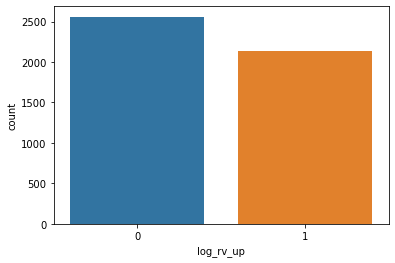

In [10]:
sns.countplot(data = data, x = 'log_rv_up')


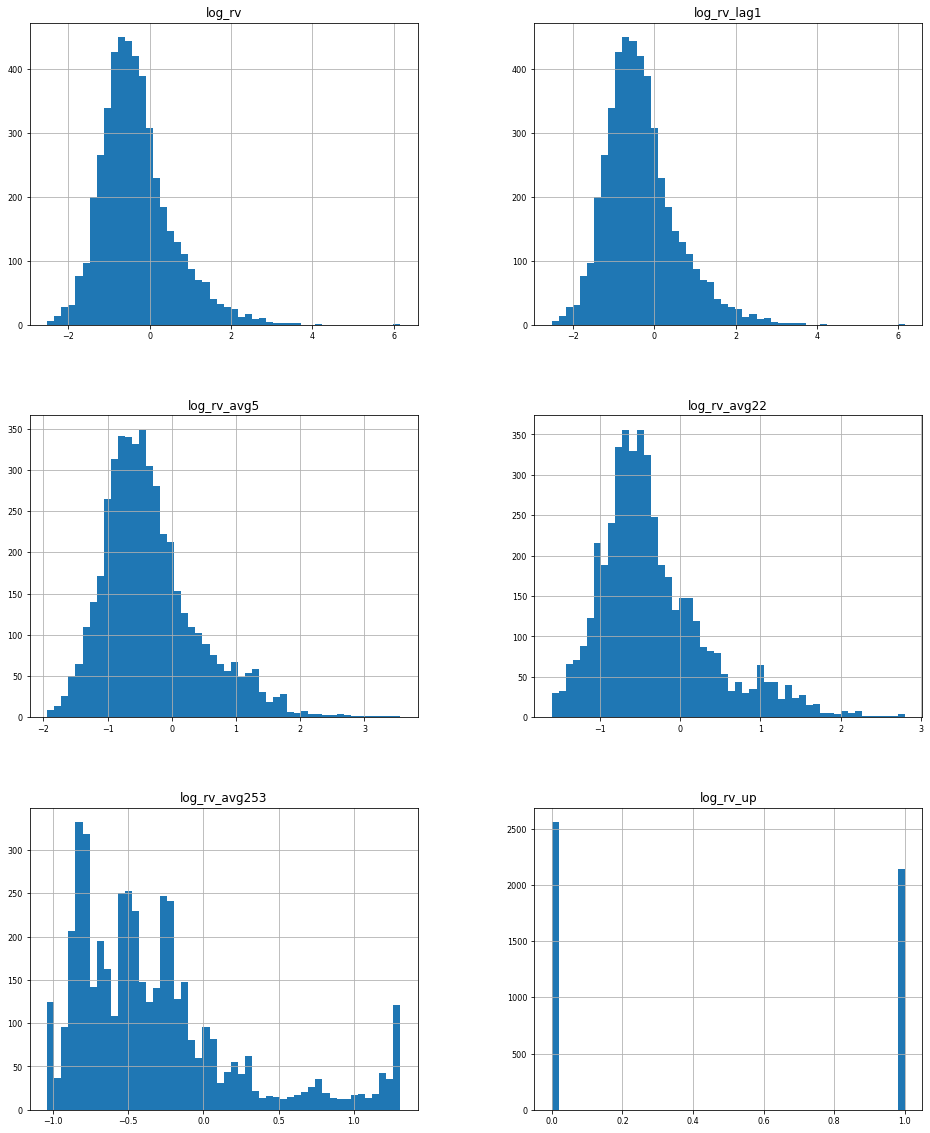

In [11]:
data.hist(figsize=(16,20), bins = 50, xlabelsize=8, ylabelsize=8);



In [12]:
print('Skewness')
data.skew()

Skewness


log_rv           0.962354
log_rv_lag1      0.962377
log_rv_avg5      1.062158
log_rv_avg22     1.160355
log_rv_avg253    1.349482
log_rv_up        0.178244
dtype: float64

In [13]:
print('Kurtosis')
data.kurtosis()

Kurtosis


log_rv           1.888579
log_rv_lag1      1.888494
log_rv_avg5      1.641399
log_rv_avg22     1.558318
log_rv_avg253    1.448866
log_rv_up       -1.969067
dtype: float64

log_rv, log_rv_lag1 ,log_rv_avg5 , log_rv_avg22 are normally distributed, while log_rv_avg253 is positively skewed.

This property of the data will be beneficial for any model we tend to use for predicting log_rv value.

# Bivariate Ananlysis

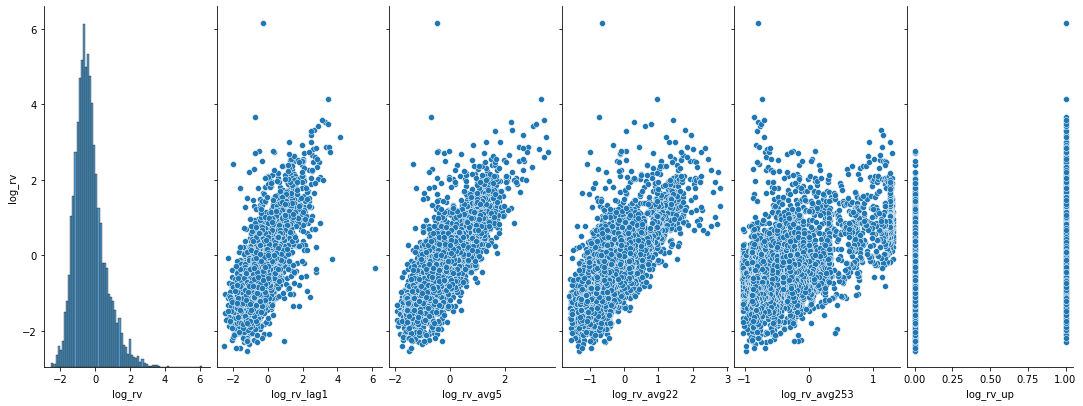

In [14]:

pair_plot = sns.pairplot(data, x_vars = data.columns, y_vars = ['log_rv'], size= 4)
pair_plot.fig.set_size_inches(15,6)


Above pairplot further shows that there is a strong linear relationship between log_rv and all other variables, except the categorical variable log_rv_up.

The correlation matrix and heatmap shown below quantifies the linear relionship between variables. 

In [15]:
data.corr()

log_rv  log_rv_lag1  log_rv_avg5  log_rv_avg22  \
log_rv         1.000000     0.715120     0.761547      0.720919   
log_rv_lag1    0.715120     1.000000     0.850714      0.750249   
log_rv_avg5    0.761547     0.850714     1.000000      0.893307   
log_rv_avg22   0.720919     0.750249     0.893307      1.000000   
log_rv_avg253  0.520703     0.525999     0.616511      0.702372   
log_rv_up      0.308505     0.331608     0.399829      0.431045   

               log_rv_avg253  log_rv_up  
log_rv              0.520703   0.308505  
log_rv_lag1         0.525999   0.331608  
log_rv_avg5         0.616511   0.399829  
log_rv_avg22        0.702372   0.431045  
log_rv_avg253       1.000000  -0.139134  
log_rv_up          -0.139134   1.000000

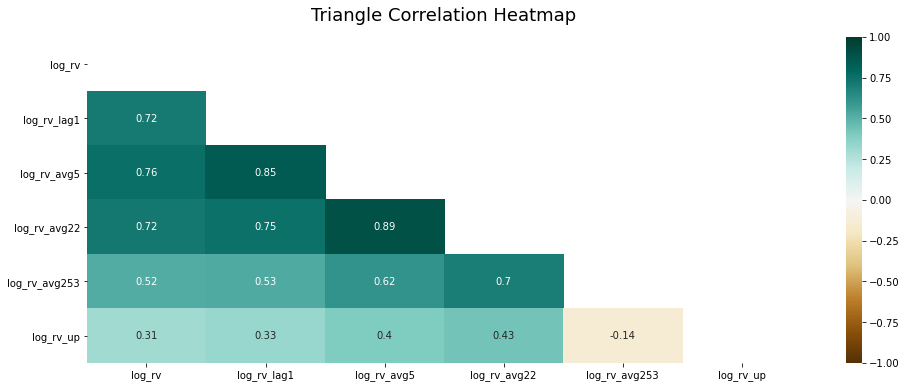

In [16]:
plt.figure(figsize=(16, 6))
mask = np.triu(np.ones_like(data.corr(), dtype=np.bool))
heatmap = sns.heatmap(data.corr(), mask=mask, vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Triangle Correlation Heatmap', fontdict={'fontsize':18}, pad=16);

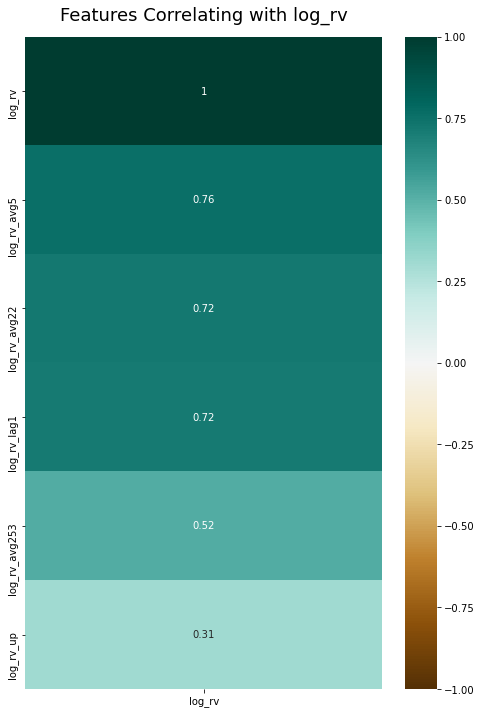

In [17]:
plt.figure(figsize=(8, 12))
heatmap = sns.heatmap((data.corr()[['log_rv']].sort_values(by='log_rv', ascending=False)), vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Features Correlating with log_rv', fontdict={'fontsize':18}, pad=16);

Due to high correlation value of log_rv_lag1, log_rv_avg5, log_rv_avg22 with log_rv, these features are highly predictive of log_rv future value, atleast one day ahead. 

Additionally, due to highly dependent nature of the variables, for instance, the value of log_rv_avg22 is the average of data points which includes log_rv_avg5, hence the predictors are highly correlated. As stated earlier, this violates a Simple Linear regression assumption.

<AxesSubplot:xlabel='log_rv_lag1', ylabel='log_rv'>

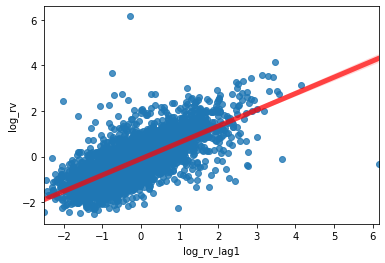

In [18]:
sns.regplot(x=data["log_rv_lag1"],y=data["log_rv"],line_kws={"color":"r","alpha":0.7,"lw":5})

<AxesSubplot:xlabel='log_rv_avg5', ylabel='log_rv'>

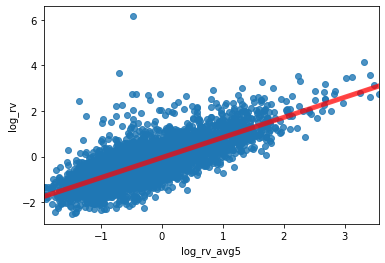

In [19]:
sns.regplot(x=data["log_rv_avg5"],y=data["log_rv"],line_kws={"color":"r","alpha":0.7,"lw":5})


<AxesSubplot:xlabel='log_rv_avg22', ylabel='log_rv'>

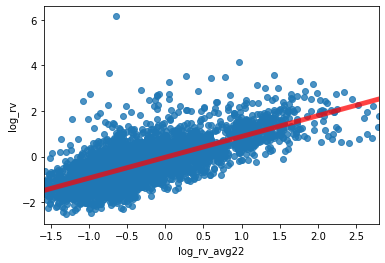

In [20]:
sns.regplot(x=data["log_rv_avg22"],y=data["log_rv"],line_kws={"color":"r","alpha":0.7,"lw":5})


<AxesSubplot:xlabel='log_rv_avg253', ylabel='log_rv'>

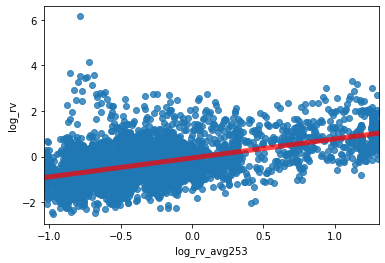

In [21]:
sns.regplot(x=data["log_rv_avg253"],y=data["log_rv"],line_kws={"color":"r","alpha":0.7,"lw":5})


<AxesSubplot:xlabel='log_rv_up', ylabel='log_rv'>

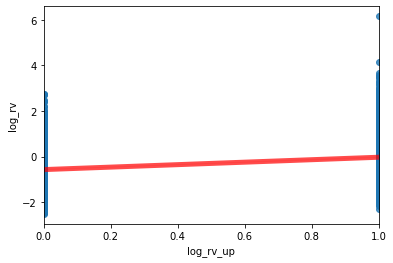

In [22]:
sns.regplot(x=data["log_rv_up"],y=data["log_rv"],line_kws={"color":"r","alpha":0.7,"lw":5})


### Detect Missing Values 

In [23]:
#Detect Missing Values
data.isnull().sum()

log_rv           0
log_rv_lag1      0
log_rv_avg5      0
log_rv_avg22     0
log_rv_avg253    0
log_rv_up        0
dtype: int64

### Detect Outliers

<AxesSubplot:xlabel='log_rv'>

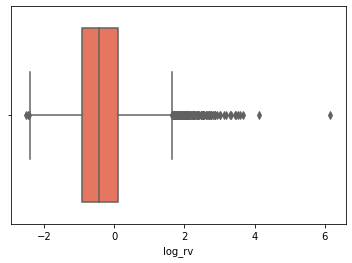

In [24]:
#Detect Outliers
sns.boxplot(x='log_rv', data=data,palette ='Reds')


<AxesSubplot:xlabel='log_rv_lag1'>

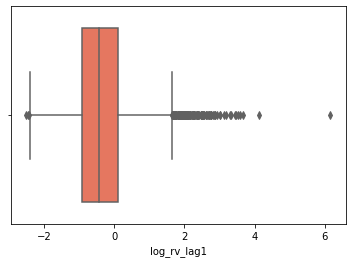

In [25]:
sns.boxplot(x='log_rv_lag1', data=data,palette ='Reds')

<AxesSubplot:xlabel='log_rv_avg5'>

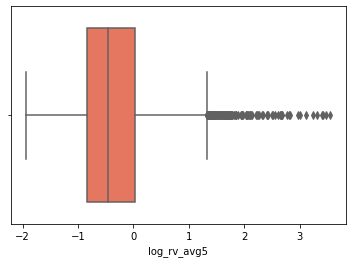

In [26]:
sns.boxplot(x='log_rv_avg5', data=data,palette ='Reds')

<AxesSubplot:xlabel='log_rv_avg22'>

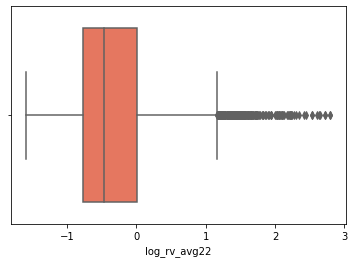

In [27]:
sns.boxplot(x='log_rv_avg22', data=data,palette ='Reds')

<AxesSubplot:xlabel='log_rv_avg253'>

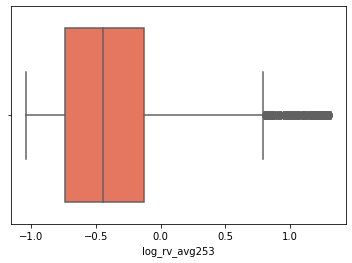

In [28]:
sns.boxplot(x='log_rv_avg253', data=data,palette ='Reds')

While, there are many outliers detected for the variables, in essence this is the property of all time-series financial data due to greater tendency to fluctuations. 

## Conclusion and Further Work

Following conclusions can be drawn from the EDA of Log_rv feature:

1. All variables in the Log_rv feature dataset are linearly correlated to log_rv value. log_rv_lag1 ,log_rv_avg5 , log_rv_avg22 predictors are predictive of future log_rv of CBA at least one day ahead.
2. Some predictors are linearly correlated to each other, which leads to multicolinearity.
3. Overall, the data quality is good - no missing values.
4. Response and Predictor variables are normally distributed.

Further Work:

1. Further work on dealing with multicolinearity in timeseries data.
2. Further work on ways to handle categorical variable(log_rv_up).

I believe that Simple linear regression model can be highly accurate in predicting log_rv value, given we can deal with multicolinearity as all other assumption of simple linear regression entails.  
Alternatively, K-nearest neigbor can also provide highly accurate prediction. It is a simple alternative worth considering.  
